In [73]:
from pydap.client import open_url
from datetime import datetime
import numpy as np
import pandas as pd
import time
import pyproj
import xarray as xr
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
import math
import pickle
from datetime import date
import os
import plotly.express as px
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def get_plot_ticks(lat_values, long_values):

    min_lat = min(lat_values)
    max_lat = max(lat_values)
    min_long = min(long_values)
    max_long = max(long_values)
    
    lat_step_size = (max_lat - min_lat) / 3
    long_step_size = (max_long - min_long) / 3

    long_list = [min_long, min_long + long_step_size, min_long + 2 * long_step_size, max_long]
    lat_list = [min_lat, min_lat + lat_step_size, min_lat + 2 * lat_step_size, max_lat]
    # Rounding to two decimals
    long_list = [round(num, 2) for num in long_list]
    lat_list = [round(num, 2) for num in lat_list]

    return lat_list, long_list

def plot_smap(df, interpolated = False):

    # Settings for the plot
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    lat_list, long_list = get_plot_ticks(df['sp_lat'], df['sp_lon'])
    ax.set_xticks(long_list, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_list, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    plt.scatter(df['sp_lon'], df['sp_lat'], c=list(np.sqrt(df['u10']**2 + df['v10']**2)), cmap='RdBu')
    bar = plt.colorbar()
    bar.ax.set_title('Wind Speed m/s')
    if interpolated:
        plt.title('Interpolated ERA5 Wind Speed')
    else:
        plt.title('ERA5 Wind Speed')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig('wind_speed.svg')
    plt.show()
    
    
def reduce_area_of_df(df):
    df = df[df.sp_lat <= 9.5]
    df = df[df.sp_lat >= -10]
    df = df[df.sp_lon >= 200]
    return df[df.sp_lon <= 210]
    

def generate_url(year, month, day, satellite_number):

    day_of_year = datetime(year, month, day).timetuple().tm_yday
    date_string = str(year) + str(month).zfill(2) + str(day).zfill(2)

    base_url = 'https://podaac-opendap.jpl.nasa.gov/opendap/hyrax/allData/cygnss/L1/v3.0/'
    specific_url = str(year) + '/' + str(day_of_year).zfill(3) + '/cyg0' + str(satellite_number) + '.ddmi.s' + \
                   date_string + '-000000-e' + date_string + '-235959.l1.power-brcs.a30.d31.nc'
    data_url = base_url + specific_url
    clickable_url = base_url + specific_url + '.html'

    return data_url + '?sp_lat,sp_lon,track_id,quality_flags,ddm_timestamp_utc,ddm_nbrcs', clickable_url



def store_cygnss_data(year, month, day):
    sat_df = pd.DataFrame()
    for sat_numb in range(1, 9): # Remember to change back to  1, 9
        print("Satellite number : " + str(sat_numb))
        test_data_url, test_clickable_url = generate_url(year, month, day, sat_numb)
        dataset = open_url(test_data_url, output_grid=False)
        for ddm in range(4):  # Remember to change back to 4
            ddm_df = pd.DataFrame()    
            print("ddm : " + str(ddm))
            sp_lat = np.array(dataset.sp_lat[:, ddm])
            sp_lon = np.array(dataset.sp_lon[:, ddm])
            #a, b = (np.where(sp_lon > 180))
            #sp_lon[a] -= 360

            ddm_timestamp_utc = np.array(dataset.ddm_timestamp_utc[:, ddm])
            d0 = date(1992, 10, 5)
            d1 = date(year, month, day)
            delta = d1 - d0
            hours = delta.days*24
            ddm_timestamp_utc = np.rint(ddm_timestamp_utc/3600) + hours
            
            ddm_nbrcs = np.array(dataset.ddm_nbrcs[:, ddm])



            ddm_df['sp_lat'] = sp_lat.tolist()
            ddm_df['sp_lon'] = sp_lon.tolist()
            '''
            track_id = np.array(dataset.track_id[:, ddm])
            quality_flags = np.array(dataset.quality_flags[:, ddm])
            ddm_df['ddm_channel'] = np.zeros(len(sp_lon))
            ddm_df = ddm_df.assign(ddm_channel=ddm)
            ddm_df['track_id'] = track_id.tolist()
            ddm_df['quality_flags'] = quality_flags.tolist()
            '''
            ddm_df['hours_since_ref'] = ddm_timestamp_utc.tolist()
            ddm_df['ddm_nbrcs'] = ddm_nbrcs.tolist()

            for col in ddm_df.columns:
                if col != 'ddm_channel' and col != 'hours_since_ref':
                    ddm_df[col] = ddm_df[col].apply(lambda x: x[0])
            sat_df = sat_df.append(ddm_df, ignore_index=True)
    sat_df.to_pickle('df.pkl')
    return sat_df

def open_oskar_data_local(filename):
    ds = xr.open_dataset(filename)
    oskar_df = ds.to_dataframe()
    oskar_df.dropna(inplace = True)
    oskar_df = oskar_df.reset_index()
    d0 = date(1992, 10, 5)
    d1 = oskar_df['time'][1].date()
    delta = d1 - d0
    hours = delta.days*24
    oskar_df['time'] = np.zeros(len(oskar_df['time']))
    oskar_df = oskar_df.assign(time=hours)
    oskar_df = oskar_df.rename(columns={"latitude": "sp_lat", "longitude": "sp_lon", "time" : "hours_since_ref"})
    oskar_df = oskar_df.loc[oskar_df['sp_lon'] < 380 ]
    oskar_df['sp_lon'] = oskar_df['sp_lon']%360
    oskar_df = reduce_area_of_df(oskar_df)
    return oskar_df

list_of_dfs = []
for filename in os.listdir('oskar_data'):
    list_of_dfs.append(open_oskar_data_local('oskar_data/' + filename))
oskar_df = pd.concat(list_of_dfs)
oskar_df

hours_since_ref     sp_lat      sp_lon  depth         u         v
123962           253992   9.333333  200.000000   15.0  0.100953 -0.009289
123963           253992   9.333333  200.333333   15.0  0.077290  0.003463
123964           253992   9.333333  200.666667   15.0  0.071818 -0.002268
123965           253992   9.333333  201.000000   15.0  0.054943 -0.014659
123966           253992   9.333333  201.333333   15.0  0.017294 -0.020006
...                 ...        ...         ...    ...       ...       ...
173724           254232 -10.000000  208.666667   15.0 -0.167086 -0.049265
173725           254232 -10.000000  209.000000   15.0 -0.191863 -0.058952
173726           254232 -10.000000  209.333333   15.0 -0.208142 -0.084709
173727           254232 -10.000000  209.666667   15.0 -0.217126 -0.104064
173728           254232 -10.000000  210.000000   15.0 -0.213702 -0.104521

[5481 rows x 6 columns]

In [2]:
sat_df = store_cygnss_data(2021, 10, 1)
sat_df

Satellite number : 1
ddm : 0
ddm : 1


KeyboardInterrupt: 

In [74]:
np.warnings.filterwarnings('ignore')
sat_df = pd.read_pickle('df.pkl')
total_df = sat_df[sat_df.ddm_nbrcs != -9999.0]
total_df.dropna(inplace = True)
log_10 = 10*np.log10(total_df.ddm_nbrcs.to_numpy())
total_df['ddm_nbrcs_log'] = log_10
total_df = reduce_area_of_df(total_df)
total_df

sp_lat      sp_lon  hours_since_ref   ddm_nbrcs  ddm_nbrcs_log
68566   -2.933609  202.195221         254122.0   19.939495      12.997142
68567   -2.917802  202.218216         254122.0   23.771650      13.760593
68568   -2.902014  202.241211         254122.0   28.302422      14.518236
68569   -2.886207  202.264191         254122.0   29.936344      14.761988
68570   -2.870396  202.287170         254122.0   29.182356      14.651203
...           ...         ...              ...         ...            ...
5492940  9.250966  208.080597         254133.0   88.937126      19.490831
5492947  9.138356  208.235596         254133.0  111.805923      20.484648
5492965  8.848788  208.633698         254133.0  105.963478      20.251562
5492999  8.301825  209.383926         254133.0  129.539459      21.124021
5493002  8.253567  209.450012         254133.0  323.042786      25.092600

[24903 rows x 5 columns]

In [61]:
#ds = xr.open_dataset('adaptor.mars.internal-1636460051.1656115-15503-16-d4e7e8a4-eb23-4930-9ae5-def374c3fe95.nc')
ds = xr.open_dataset('hele_verden_1_okt.nc')
df = ds.to_dataframe()
index_long = df.index.levels[0]
index_lat = df.index.levels[1]
index_time = df.index.levels[2]
u10 = df["u10"].to_numpy()
v10 = df["v10"].to_numpy()

start_time = pd.Timestamp(1992, 10, 5)
index_time_fixed = []
for tid in index_time:
    hours = tid - start_time
    index_time_fixed.append(hours.days*24 + hours.seconds/3600)

long, lat, time = np.meshgrid(index_long, index_lat, index_time_fixed, indexing = 'ij')

long = long.flatten()
#a = (np.where(long > 180))
#long[a] -= 360
lat = lat.flatten()
time = time.flatten()

era_5_df = pd.DataFrame({'sp_lon': long, 'sp_lat' :lat, 'hours_since_ref': time, 'u10': u10, 'v10': v10})
era_5_df = reduce_area_of_df(era_5_df)
era_5_df

sp_lon  sp_lat  hours_since_ref       u10       v10
13850928   200.0     9.5         254112.0 -3.505194  3.381651
13850929   200.0     9.5         254113.0 -3.053865  3.340508
13850930   200.0     9.5         254114.0 -2.894907  2.873244
13850931   200.0     9.5         254115.0 -2.468178  2.413817
13850932   200.0     9.5         254116.0 -2.191893  1.877003
...          ...     ...              ...       ...       ...
14544979   210.0   -10.0         254131.0 -8.444265  0.311621
14544980   210.0   -10.0         254132.0 -7.875610  0.203866
14544981   210.0   -10.0         254133.0 -7.430904  0.352764
14544982   210.0   -10.0         254134.0 -7.462128  1.067863
14544983   210.0   -10.0         254135.0 -7.587024  1.022802

[77736 rows x 5 columns]

In [75]:
interp_u10 = LinearNDInterpolator(list(zip(era_5_df['sp_lon'], era_5_df['sp_lat'], era_5_df['hours_since_ref'])), era_5_df['u10'])
print("done")
interp_v10 = LinearNDInterpolator(list(zip(era_5_df['sp_lon'], era_5_df['sp_lat'], era_5_df['hours_since_ref'])), era_5_df['v10'])

done


In [76]:
lons_to_interpolate = total_df["sp_lon"].to_numpy()
lats_to_interpolate = total_df["sp_lat"].to_numpy()
times_to_interpolate = total_df["hours_since_ref"].to_numpy()

u10 = interp_u10(lons_to_interpolate, lats_to_interpolate, times_to_interpolate)
v10 = interp_v10(lons_to_interpolate, lats_to_interpolate, times_to_interpolate)

In [77]:
pd.set_option('display.max_rows', 10)
cygnss_and_wind_df = pd.DataFrame({'sp_lon': lons_to_interpolate, 'sp_lat' :lats_to_interpolate, 'hours_since_ref': times_to_interpolate, 'u10': u10, 'v10': v10, 'nbrcs_log' : total_df['ddm_nbrcs_log'].to_numpy(), 'nbrcs' : total_df['ddm_nbrcs'].to_numpy()})
cygnss_and_wind_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
0      202.195221 -2.933609         254122.0 -8.185357  0.992041  12.997142   
1      202.218216 -2.917802         254122.0 -8.185373  0.988584  13.760593   
2      202.241211 -2.902014         254122.0 -8.185387  0.985131  14.518236   
3      202.264191 -2.886207         254122.0 -8.183954  0.982507  14.761988   
4      202.287170 -2.870396         254122.0 -8.181623  0.980400  14.651203   
...           ...       ...              ...       ...       ...        ...   
24898  208.080597  9.250966         254133.0 -1.000346  3.832222  19.490831   
24899  208.235596  9.138356         254133.0 -1.436784  3.450716  20.484648   
24900  208.633698  8.848788         254133.0 -1.329430  3.591969  20.251562   
24901  209.383926  8.301825         254133.0 -0.557644  5.690558  21.124021   
24902  209.450012  8.253567         254133.0 -0.529416  5.893109  25.092600   

            nbrcs  
0       19.939495  
1       23.771650  
2       28.302422  
3       29.936344  
4       29.182356  
...           ...  
24898   88.937126  
24899  111.805923  
24900  105.963478  
24901  129.539459  
24902  323.042786  

[24903 rows x 7 columns]

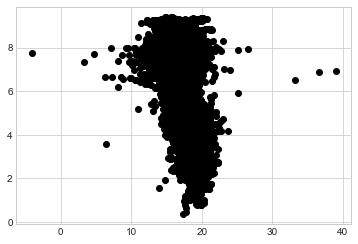

In [101]:
plot_df = pd.DataFrame({'NBRCS_LOG_SCALED' : cygnss_and_wind_df['nbrcs_log'].to_numpy(), 'Wind_Speed' : np.sqrt(cygnss_and_wind_df['u10']**2+cygnss_and_wind_df['v10']**2)})
plot_df = plot_df[plot_df.NBRCS_LOG_SCALED > 13]
plot_df = plot_df[plot_df.NBRCS_LOG_SCALED < 20]
plot_df = plot_df[plot_df.Wind_Speed > 5]

fig = px.density_heatmap(plot_df, x="NBRCS_LOG_SCALED", y="Wind_Speed", title="2D Histogram plot of Wind speed and NBRCS in DB scale")

fig.show()

plt.style.use('seaborn-whitegrid')
plt.plot((cygnss_and_wind_df['nbrcs_log'].to_numpy()), np.sqrt(cygnss_and_wind_df['u10']**2+cygnss_and_wind_df['v10']**2), 'o', color='black');

In [67]:
era_5_df_one_hour = era_5_df.loc[(era_5_df['hours_since_ref'] == 254122)]
cygnss_and_wind_df_one_hour = cygnss_and_wind_df.loc[(cygnss_and_wind_df['hours_since_ref'] == 254122)]

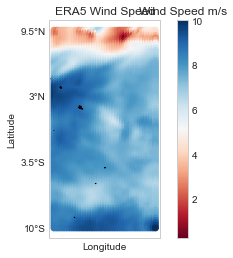

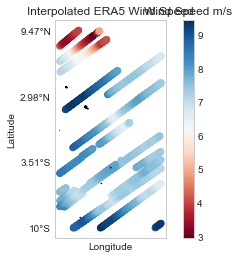

In [69]:
plot_smap(era_5_df_one_hour)
plot_smap(cygnss_and_wind_df_one_hour, interpolated= True)

In [70]:
interp_u = LinearNDInterpolator(list(zip(oskar_df['sp_lat'], oskar_df['sp_lon'], oskar_df['hours_since_ref'])), oskar_df['u'])
print("done")
interp_v = LinearNDInterpolator(list(zip(oskar_df['sp_lat'], oskar_df['sp_lon'], oskar_df['hours_since_ref'])), oskar_df['v'])

done


In [87]:
lons_to_interpolate = total_df["sp_lon"].to_numpy()
lats_to_interpolate = total_df["sp_lat"].to_numpy()
times_to_interpolate = total_df["hours_since_ref"].to_numpy()

u_current = interp_u(lats_to_interpolate, lons_to_interpolate, times_to_interpolate)
v_current = interp_v(lats_to_interpolate, lons_to_interpolate, times_to_interpolate)

cygnss_and_wind_df['u_current'] = u_current
cygnss_and_wind_df['v_current'] = v_current
cygnss_and_wind_df

sp_lon    sp_lat  hours_since_ref       u10       v10  nbrcs_log  \
0      202.195221 -2.933609         254122.0 -8.185357  0.992041  12.997142   
1      202.218216 -2.917802         254122.0 -8.185373  0.988584  13.760593   
2      202.241211 -2.902014         254122.0 -8.185387  0.985131  14.518236   
3      202.264191 -2.886207         254122.0 -8.183954  0.982507  14.761988   
4      202.287170 -2.870396         254122.0 -8.181623  0.980400  14.651203   
...           ...       ...              ...       ...       ...        ...   
24898  208.080597  9.250966         254133.0 -1.000346  3.832222  19.490831   
24899  208.235596  9.138356         254133.0 -1.436784  3.450716  20.484648   
24900  208.633698  8.848788         254133.0 -1.329430  3.591969  20.251562   
24901  209.383926  8.301825         254133.0 -0.557644  5.690558  21.124021   
24902  209.450012  8.253567         254133.0 -0.529416  5.893109  25.092600   

            nbrcs  u_current  v_current  
0       19.939495  -0.363265  -0.174035  
1       23.771650  -0.362987  -0.171106  
2       28.302422  -0.362711  -0.167713  
3       29.936344  -0.362447  -0.161729  
4       29.182356  -0.362183  -0.155745  
...           ...        ...        ...  
24898   88.937126   0.283515  -0.159647  
24899  111.805923   0.305164  -0.205431  
24900  105.963478   0.397529  -0.224189  
24901  129.539459   0.513318  -0.051962  
24902  323.042786   0.506854  -0.036226  

[24903 rows x 9 columns]

In [102]:
plot_current_df = pd.DataFrame({'NBRCS_LOG_SCALED' : cygnss_and_wind_df['nbrcs_log'].to_numpy(), 'Ocean_current_speed_15_meters_depth' : np.sqrt(cygnss_and_wind_df['u_current']**2+cygnss_and_wind_df['v_current']**2)})
plot_current_df = plot_current_df[plot_current_df.NBRCS_LOG_SCALED > 13]
plot_current_df = plot_current_df[plot_current_df.NBRCS_LOG_SCALED < 20]
plot_current_df = plot_current_df[plot_current_df.Ocean_current_speed_15_meters_depth < 1.1]
fig = px.density_heatmap(plot_current_df, x="NBRCS_LOG_SCALED", y="Ocean_current_speed_15_meters_depth", title="2D Histogram plot of Ocean current strength at 15 meters depth and NBRCS in DB scale")
fig.show()